In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import zarr
import os
import einops
%load_ext autoreload

from transformers import ViTForImageClassification, ViTImageProcessor, ViTFeatureExtractor, ViTConfig, ViTModel, pipeline
from diffusers import AutoencoderKL
from torch.utils.data import DataLoader

from utils import get_directories, get_imgs, get_device
from data_preprocessing import preprocess_images,XrdDataset

/Users/yarongli/anaconda3/envs/deeplearning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%autoreload 2

### Data Preparation

In [3]:
path = 'data'
# directories = get_directories(path)[:2]
# imgs,_ = get_imgs(directories)
# imgs = preprocess_images(imgs)
# device = get_device()
# Images are now of shape (Batch, 1667, 1665,1)
# imgs = einops.rearrange(imgs, 'b h w c -> b c h w') # This may be optional since we have a feature extractor


In [4]:
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
dataset = XrdDataset(data_dir=path, feature_extractor=feature_extractor)

In [5]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
sample = next(iter(dataloader))

Loading data/mfxl1025422_r0313_peaknet.0036.zarr/images


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


In [9]:
for batch in dataloader:
    pixel_values = batch
    print(pixel_values.shape)
    

Loading data/mfxl1027522_r0030_peaknet.0069.zarr/images
torch.Size([1, 40, 3, 224, 224])
Loading data/mfxl1027522_r0030_peaknet.0070.zarr/images
torch.Size([1, 40, 3, 224, 224])
Loading data/mfxl1027522_r0030_peaknet.0074.zarr/images
torch.Size([1, 40, 3, 224, 224])
Loading data/mfxl1027522_r0030_peaknet.0073.zarr/images
torch.Size([1, 40, 3, 224, 224])
Loading data/mfxl1027522_r0030_peaknet.0071.zarr/images
torch.Size([1, 40, 3, 224, 224])
Loading data/mfxl1027522_r0030_peaknet.0072.zarr/images
torch.Size([1, 40, 3, 224, 224])


In [6]:
from einops import rearrange
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
sample = next(iter(dataloader))
print(sample.shape)
sample = einops.rearrange(sample, 'f b c w h -> (f b) c w h')
# sample = sample.squeeze(0)
# print(sample.shape)
# sample = sample[:1]


Loading data/mfxl1025422_r0313_peaknet.0033.zarr/images
torch.Size([1, 40, 3, 224, 224])


In [7]:
print(sample.shape)

torch.Size([40, 3, 224, 224])


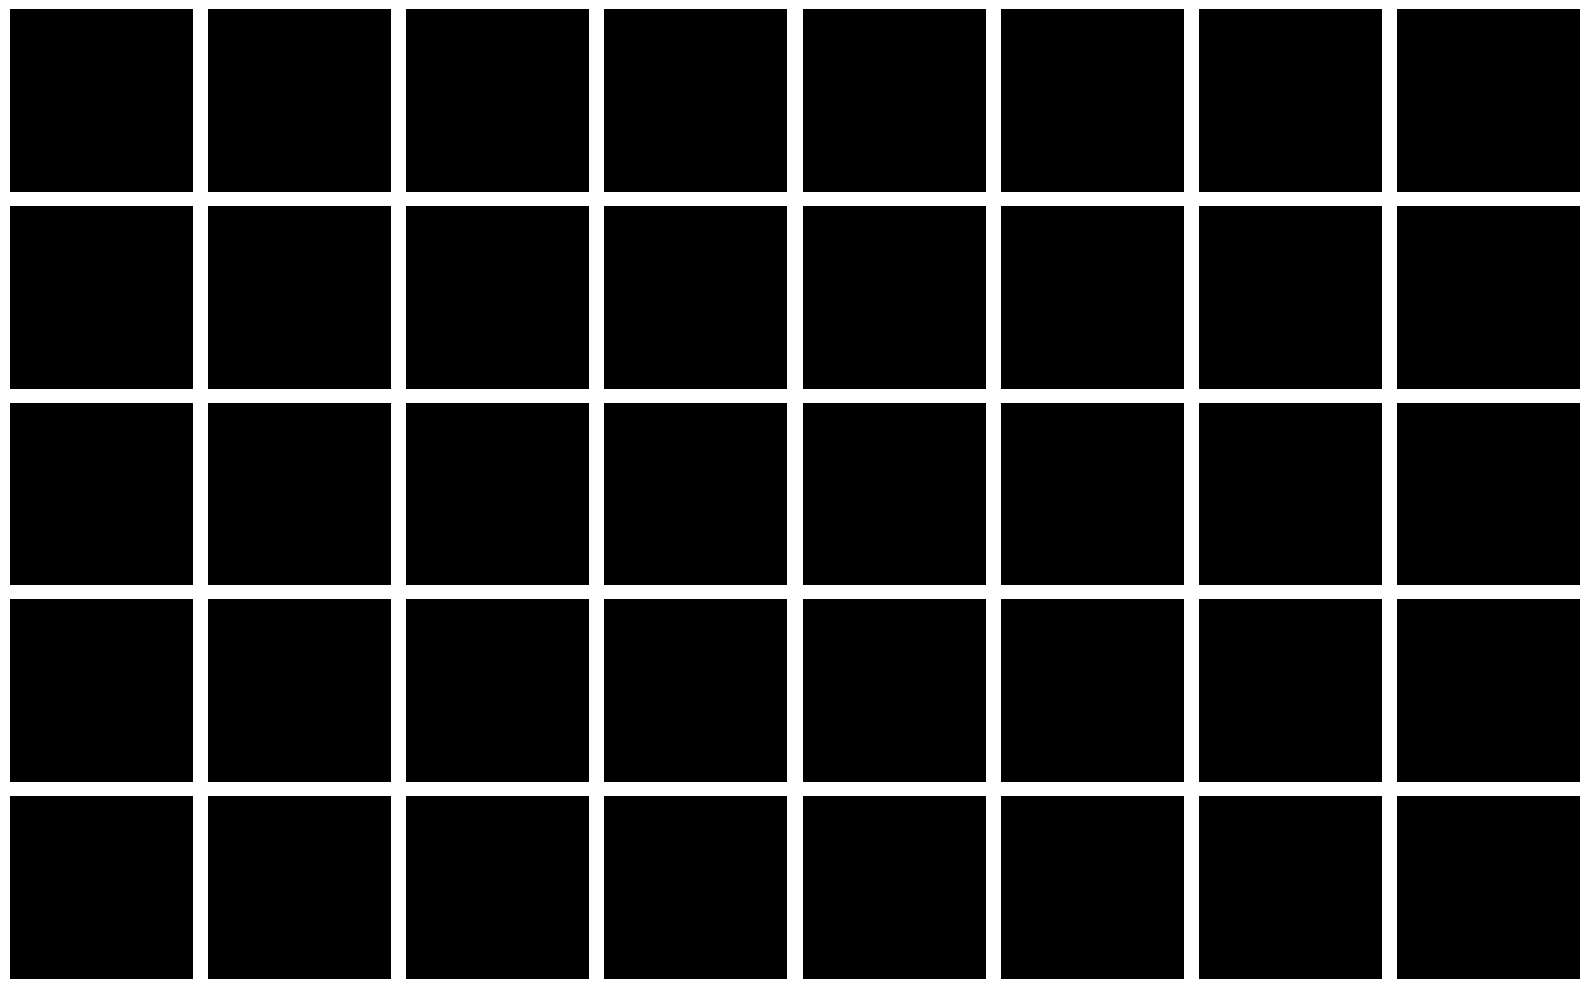

In [ ]:
import torch
import matplotlib.pyplot as plt

gray_images = sample[:, 0, :, :]

# Number of rows and columns for the grid
n_rows, n_cols = 5, 8  # 5x8 grid for 40 images

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 10))

for idx, ax in enumerate(axes.flat):
    ax.imshow(gray_images[idx].cpu(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()


### Model Instantiation & reconstruct image

In [8]:
# Load the autoencoder model.
device = get_device()
url = "https://huggingface.co/stabilityai/sd-vae-ft-mse-original/blob/main/vae-ft-mse-840000-ema-pruned.safetensors"
vae = AutoencoderKL.from_single_file(url)
vae.train()  # Set model to training mode.
vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-4)
criterion = nn.MSELoss()


In [9]:
# Sample variables from latent space
input_image = sample
with torch.no_grad():
    # input_image: (B, C, W, H) tensor, normalized to [0,1] or appropriate scale
    input_image = input_image.to(device)
    posterior = vae.encode(input_image).latent_dist
    latent = posterior.sample() 




In [13]:
print(latent.shape)

torch.Size([40, 4, 28, 28])


#### Generate New Samples

In [14]:
# Sample 2 latent vectors from the standard normal prior
num_samples = 2
latent_shape = (4, 28, 28)
sampled_latents = torch.randn(num_samples, *latent_shape).to(device)


In [18]:
with torch.no_grad():
    generated_images = vae.decode(sampled_latents).sample  # Output shape: [40, C, H, W]

In [19]:
print(generated_images.shape)

torch.Size([2, 3, 224, 224])


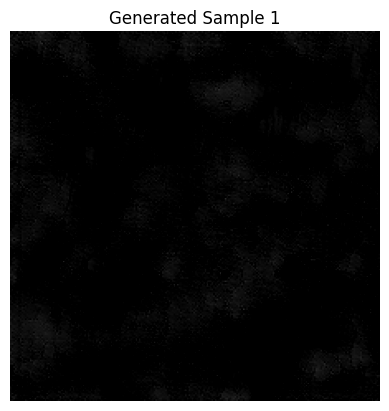

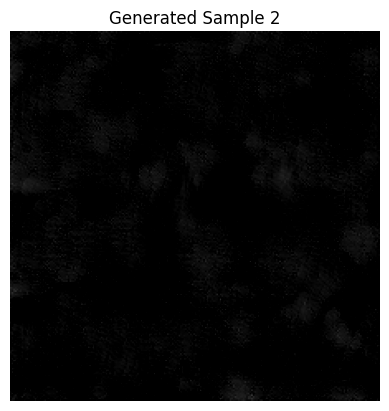

In [25]:
import matplotlib.pyplot as plt

# Convert from (2, 3, 224, 224) to (2, 224, 224) by taking just the first channel
gray_images = generated_images[:, 0, :, :] 

# Visualize each image
for i in range(gray_images.shape[0]):
    plt.figure()
    plt.imshow(gray_images[i].cpu(), cmap='gray', vmin=0, vmax=1)
    plt.title(f'Generated Sample {i+1}')
    plt.axis('off')
    plt.show()


#### Generate Samples Conditioned on Real Images

In [26]:
with torch.no_grad():
    recon = vae.decode(latent).sample

In [38]:
print(recon.shape)
print(input_image.shape)

torch.Size([40, 224, 224])
torch.Size([40, 3, 224, 224])


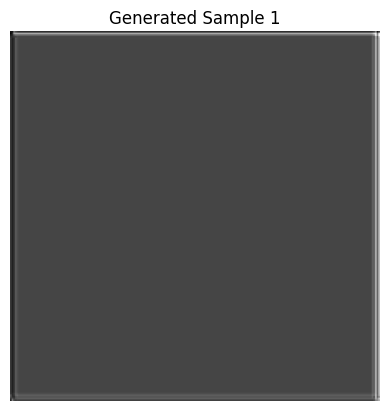

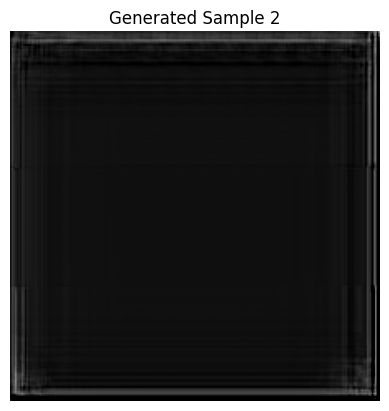

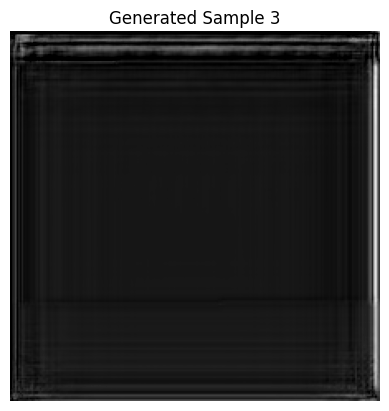

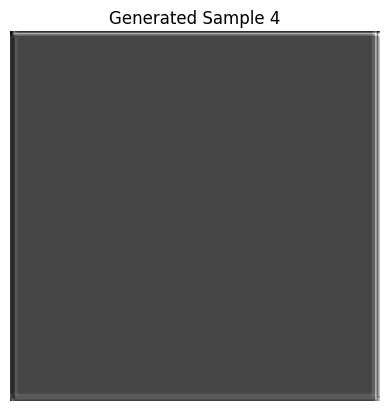

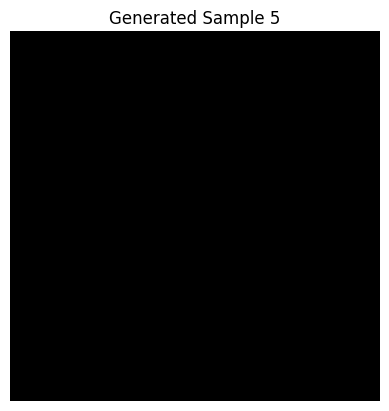

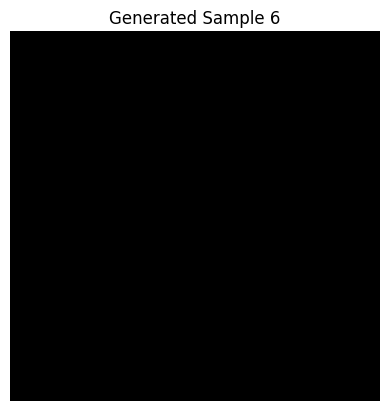

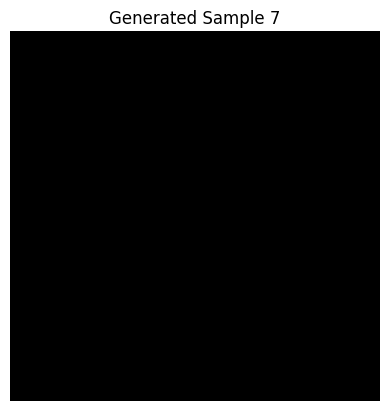

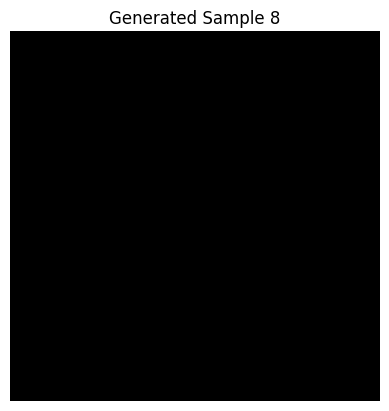

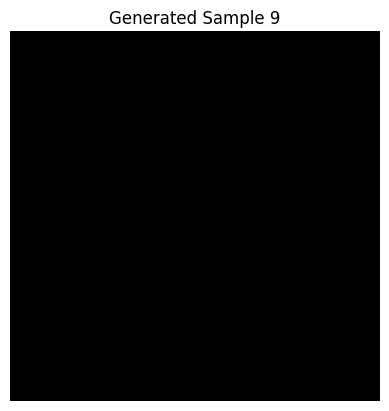

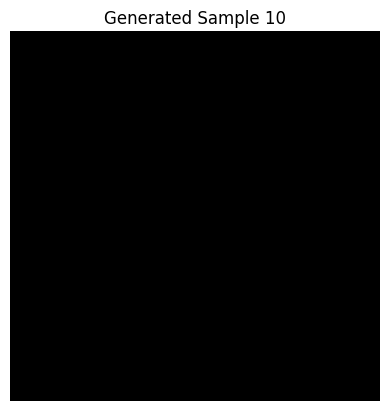

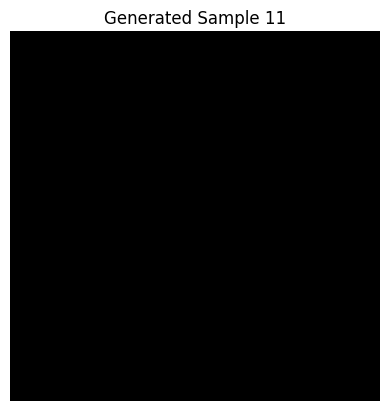

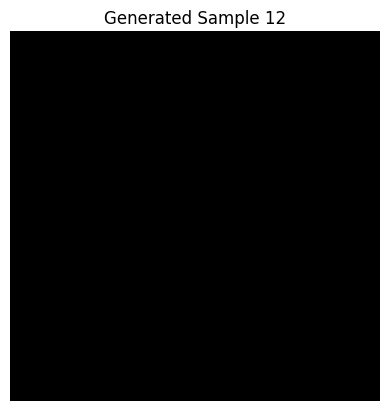

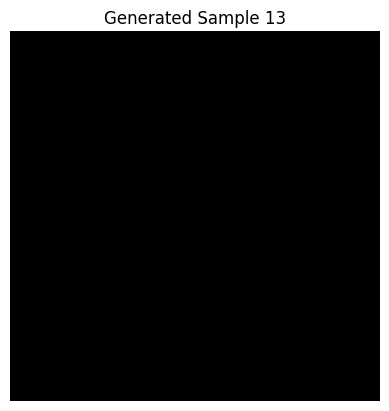

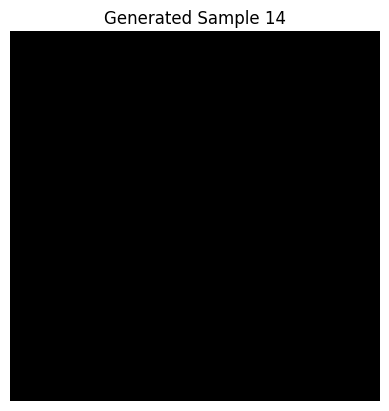

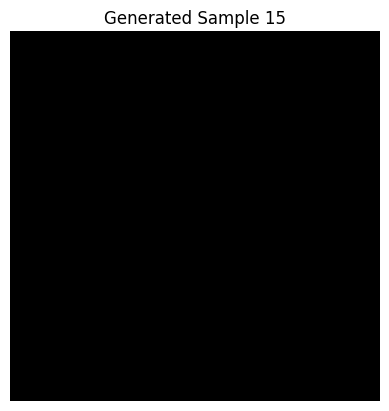

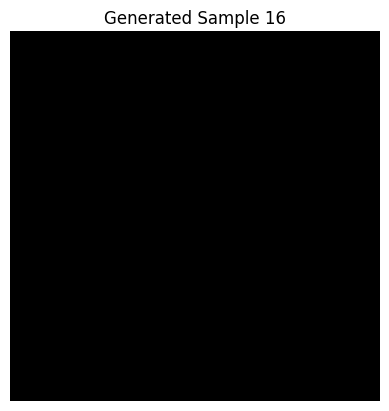

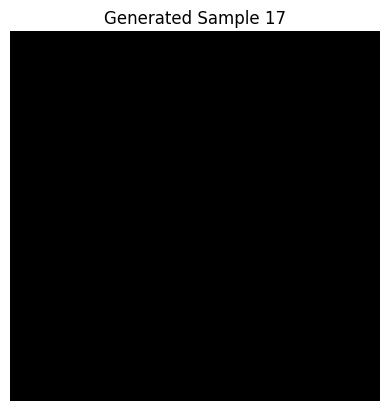

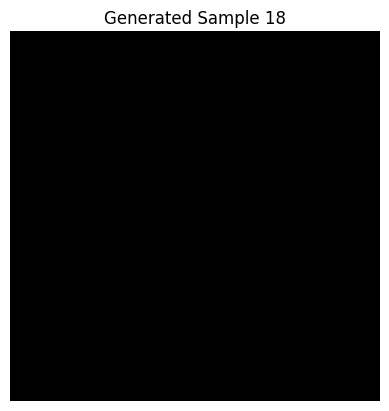

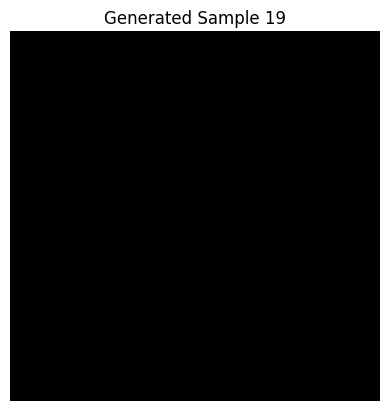

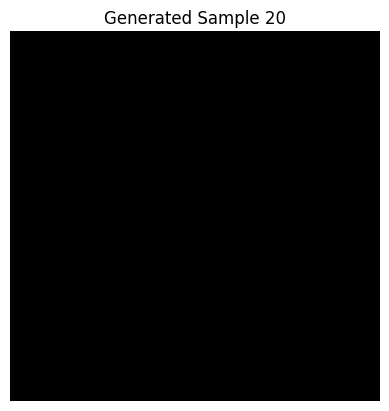

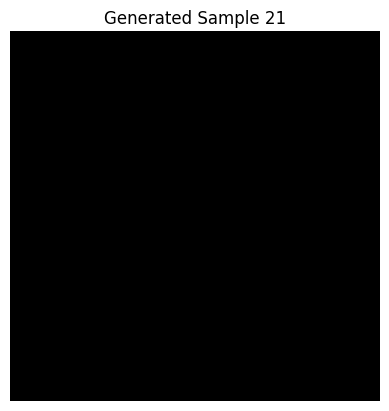

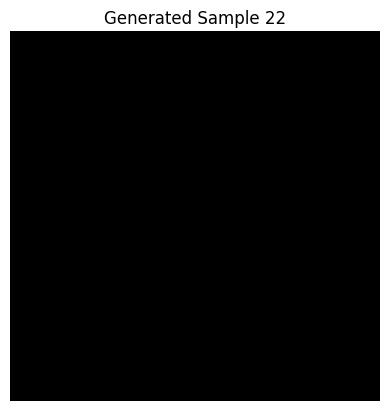

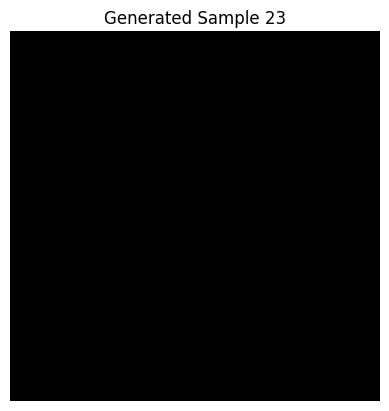

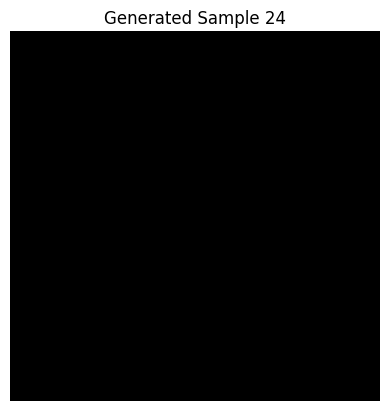

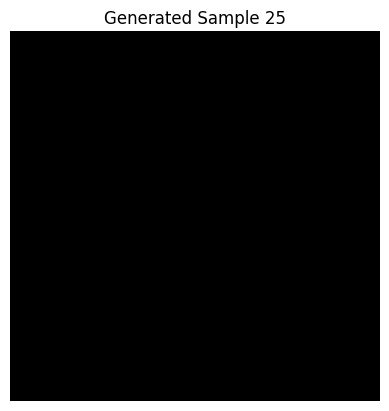

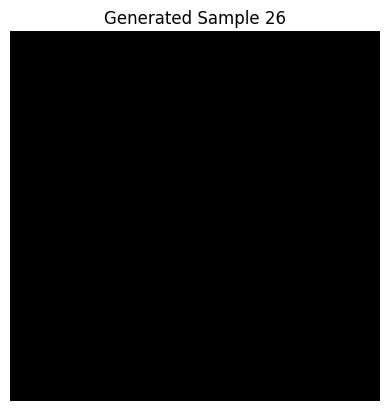

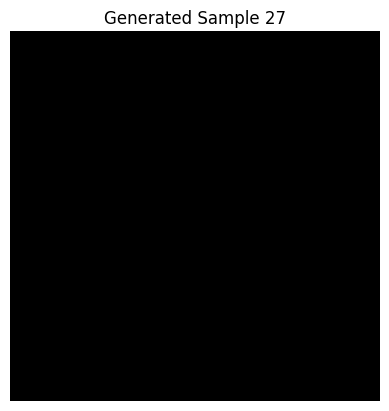

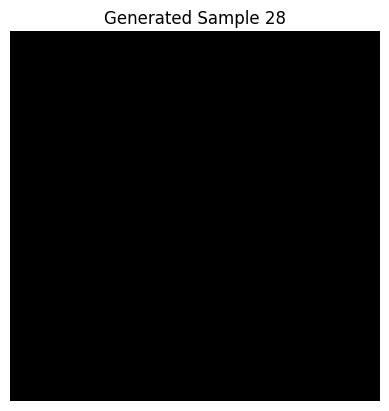

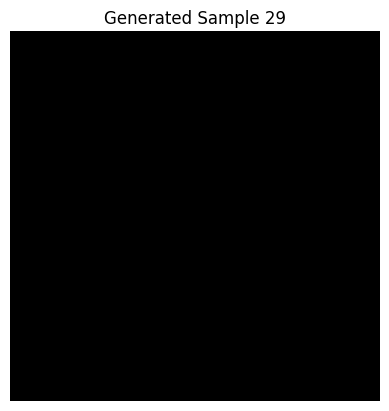

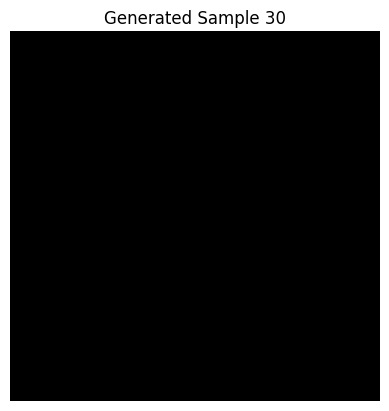

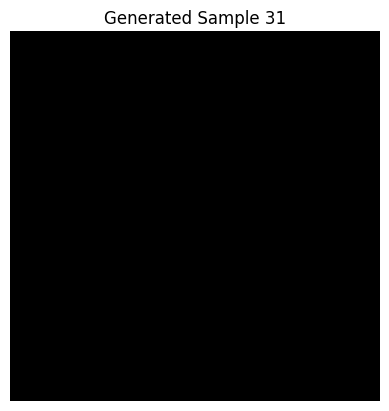

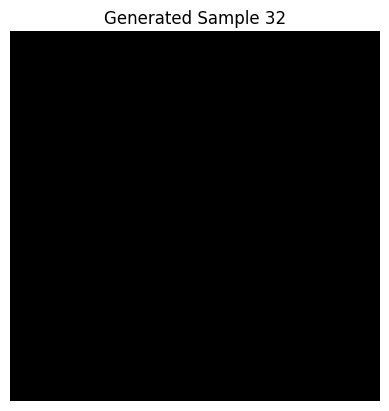

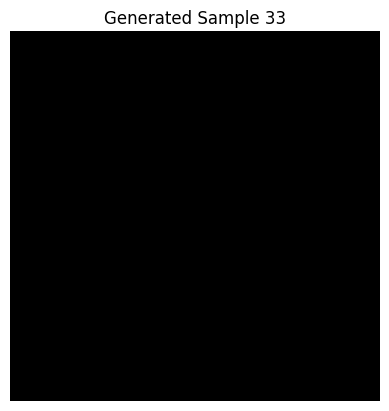

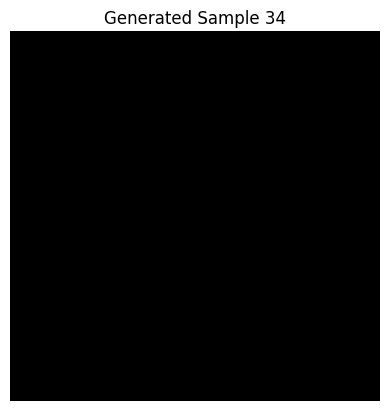

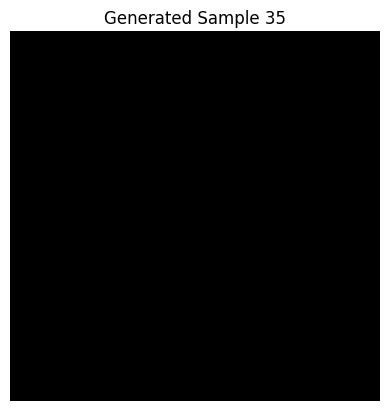

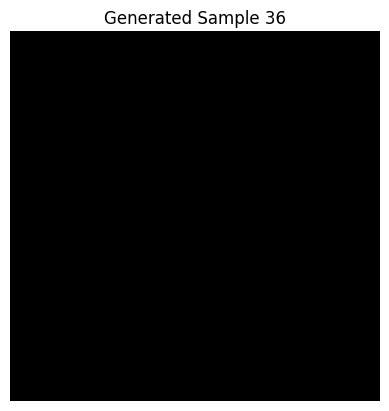

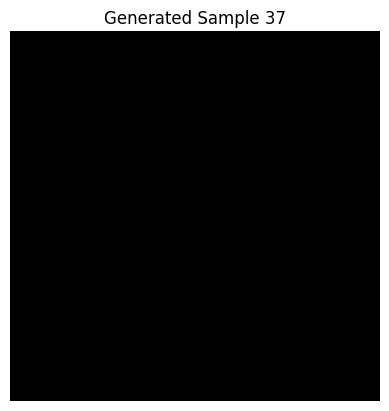

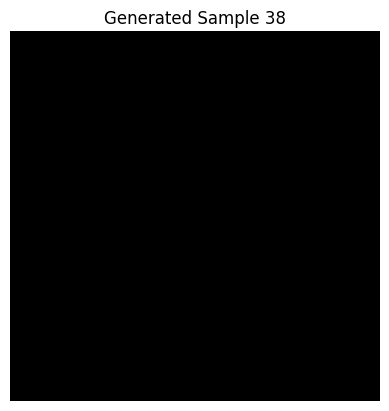

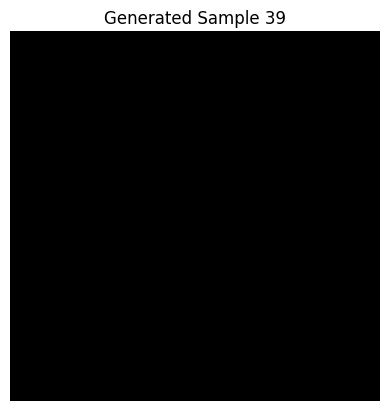

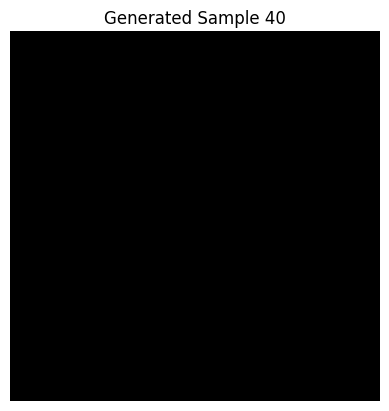

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

recon_first_ch= recon[:, 0, :, :]  # Take the first channel

# Visualize each image
for i in range(recon_first_ch.shape[0]):
    plt.figure()
    plt.imshow(recon_first_ch[i].cpu(), cmap='gray', vmin=0, vmax=1)
    plt.title(f'Generated Sample {i+1}')
    plt.axis('off')
    plt.show()

